In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.signal import chirp
from scipy.special import hyperu, laguerre, genlaguerre, hyp1f1
from scipy.constants import hbar
from scipy.constants import k as kB
from tqdm import tqdm
import dill
from scipy.integrate import quad
import qcontrol as qc

In [69]:
qargs = {
    'optical_fc':           2e9, 
    'optical_df':           0.3e9,
    'mw_fc':                1.3e9, 
    'optical_lifetime':     1/6e-9, 
    'branching_ratio':      0.0005,
    'dark_count_rate':      10e3,
    'coupling_efficiency':  0.002,
    'debye_waller_factor':  0.8,
    'non_radiative_factor': 0.6,
    }
q = qc.ColorCenterQubit(**qargs)
pulses = {
    'pi' : {
        'frequency' : q.mw_fc,
        'width' : 115.4e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'pi/2' : {
        'frequency' : q.mw_fc,
        'width' : 62.5e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'readout_down' : {
        'frequency' : q.f0,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    },
    'readout_up' : {
        'frequency' : q.f1,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    }
}


phase_flags = { '_X' : 0, '_Y' : np.pi/2, '_-X' : np.pi, '_-Y' : -np.pi/2}

def process_pulse_train(t, pulse_sequence, plot=False):
    pulse_sigs = {}
    for channel, pulse_dict in pulse_sequence.items():
        pulse_sigs[channel] = np.zeros_like(t, dtype=complex)
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                envelope = qc.tools.__smooth_square_pulse(None, t, current_time, pulses[p]['width'], pulses[p]['t_ramp'], pulses[p]['amplitude'])
                modulation = np.cos(2*np.pi*pulses[p]['frequency']*t+phase)
                pulse_sigs[channel] += envelope*modulation
                if plot:
                    plt.plot(t*1e6, envelope/np.max(envelope), label=f"{channel} Envelope")
                current_time += pulses[p]['width']
            else:
                current_time += p
    if plot:
        for channel, pulse_sig in pulse_sigs.items():
            plt.plot(t*1e6, pulse_sig/np.max(pulse_sig), label=channel)

        plt.legend()
        plt.xlabel('Time (us)')
        plt.ylabel('Pulse Amplitude')
        plt.title('Pulse Sequence')
        
    return pulse_sigs

def get_pulse_train_time(pulse_sequence):
    max_time = 0
    for channel, pulse_dict in pulse_sequence.items():
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                current_time += pulses[p]['width']
            else:
                current_time += p
        max_time = max(max_time, current_time)
    return max_time


/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


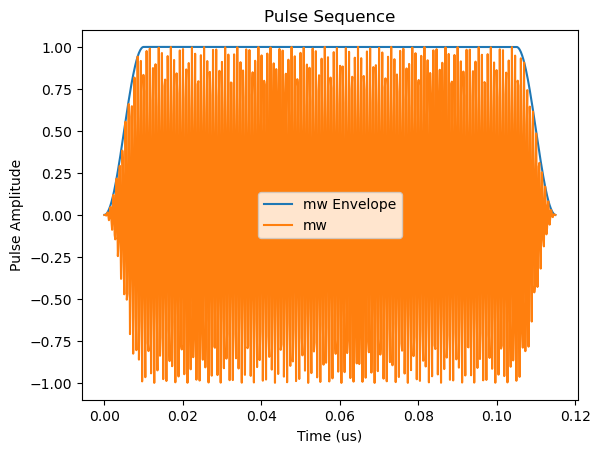

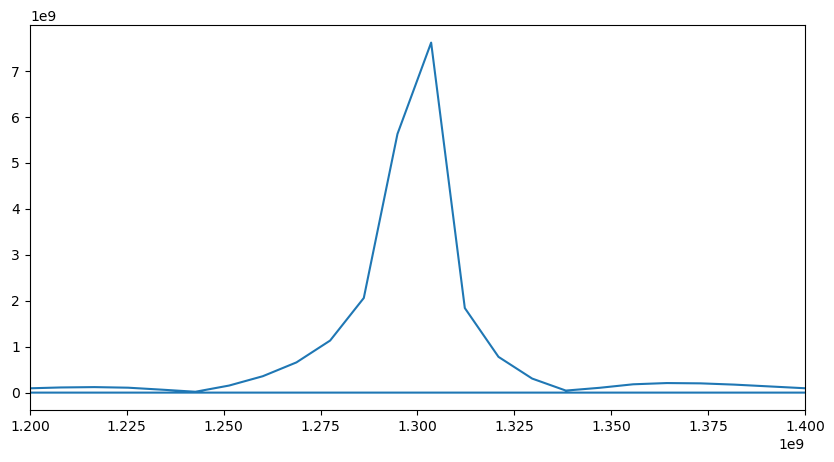

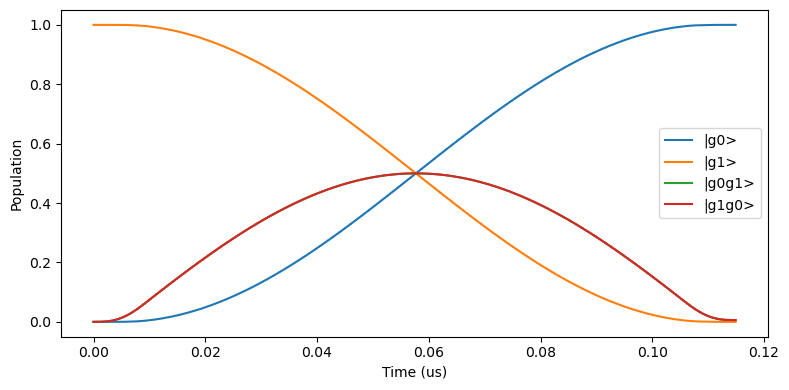

0.9999635351208128


In [3]:
ramsey_sequence = {
    'mw' : {'pulse_train' : ['pi_X']},
    # 'optical' : {'pulse_train' : [pulses['pi/2']['width'], wait_time, pulses['pi/2']['width'], wait_time, 'readout_up']}
}
t = np.arange(0, get_pulse_train_time(ramsey_sequence), 1/6.144e9)
ramsey_sigs = process_pulse_train(t, ramsey_sequence, plot=True)
# Plot the fourier transform of the pulse
plt.figure(figsize=(10, 5))
freqs = np.fft.fftfreq(len(t), t[1]-t[0])
plt.plot(freqs, np.abs(np.fft.fft(ramsey_sigs['mw'])))
plt.xlim(1.2e9, 1.4e9)
plt.show()

# q = qc.ColorCenterQubit(**qargs)
result = q.apply_pulse_sequence(t, ramsey_sigs, plot=True)
print(np.abs(result.expect[0][-1]))

  0%|          | 0/1 [00:00<?, ?it/s]

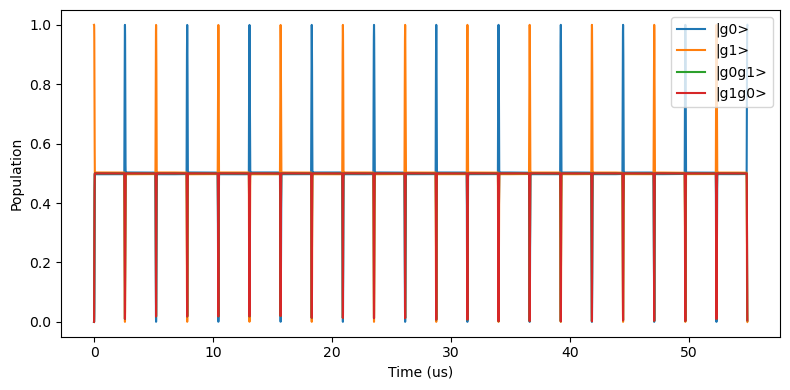

100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


In [70]:

wait_times = np.linspace(5e-6, 50e-6, 1)
transfer = []
for wait_time in tqdm(wait_times):
    ramsey_flips = 20
    ramsey_sequence = {
        'mw' : {'pulse_train' : ['pi/2_X', wait_time/2-26.25e-9, 'pi_X'] + [wait_time/2, 'pi_X']*(ramsey_flips-1) + [wait_time/2-26.25e-9, 'pi/2_X']},
        # 'optical' : {'pulse_train' : [\pulses['pi/2']['width'], wait_time, pulses['pi/2']['width'], wait_time, 'readout_up']}
    }
    t = np.arange(0, get_pulse_train_time(ramsey_sequence), 1/6.144e9)
    ramsey_sigs = process_pulse_train(t, ramsey_sequence, plot=False)   
    q = qc.ColorCenterQubit(**qargs)
    result = q.apply_pulse_sequence(t, ramsey_sigs, plot=True)
    

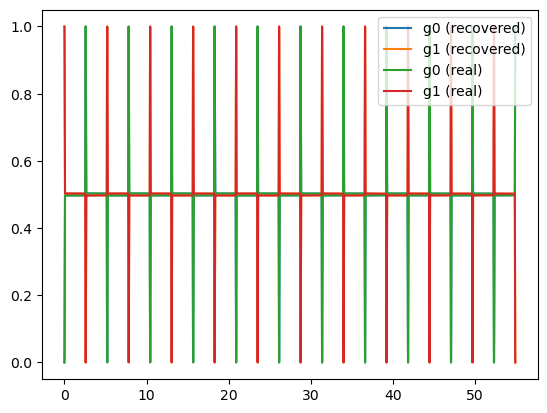

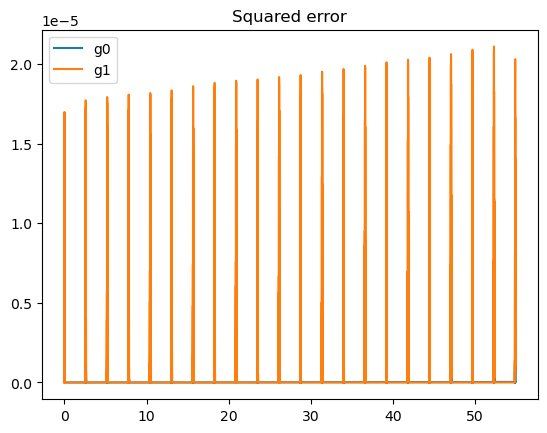

/tmp/ipykernel_2903581/843928928.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


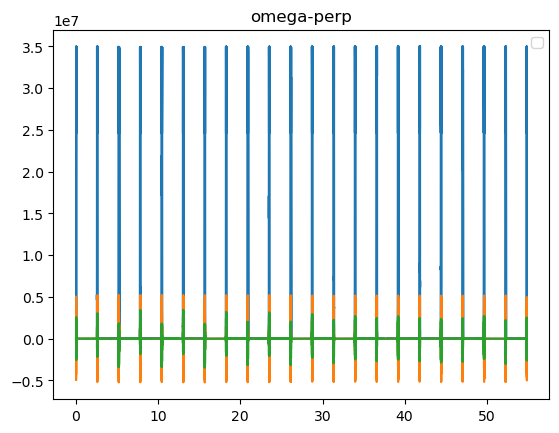

/tmp/ipykernel_2903581/843928928.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


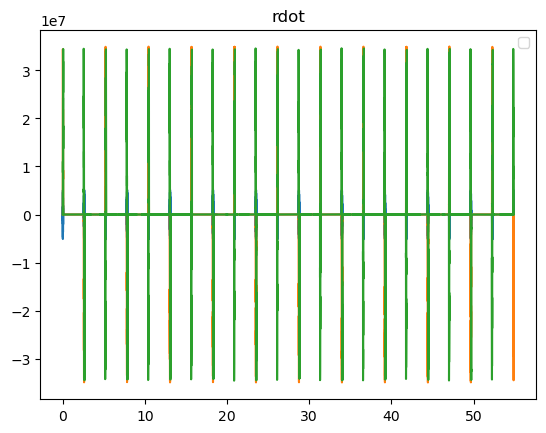

In [71]:
def rodrigues_rotate(v, n, theta):
    # v: (3,), n: (3,) unit axis, theta: scalar
    c, s = np.cos(theta), np.sin(theta)
    return v*c + np.cross(n, v)*s + n*np.dot(n, v)*(1 - c)

def integrate_bloch(Omega, tlist, r0):
    # Omega: (N,3) array of angular velocity vectors (rad/s in your units)
    r = np.zeros((len(tlist), 3), dtype=float)
    r[0] = r0
    for k in range(len(tlist)-1):
        dt = tlist[k+1] - tlist[k]
        Om = Omega[k]
        w = np.linalg.norm(Om)
        if w < 1e-15:
            r[k+1] = r[k]
        else:
            n = Om / w
            r[k+1] = rodrigues_rotate(r[k], n, w*dt)
    return r

def rotating_frame_states(tlist, states, omega):
    """
    Transform QuTiP states into a rotating frame defined by
        H_rot = (omega/2) * sigma_z

    Parameters
    ----------
    tlist : array-like
        Time points corresponding to the states
    states : list of Qobj
        State vectors (kets) or density matrices
    omega : float
        Rotation frequency

    Returns
    -------
    states_rot : list of Qobj
        States in the rotating frame
    """
    sz = qt.sigmaz()
    states_rot = []

    for t, state in zip(tlist, states):
        U = (-1j * omega * t * sz / 2).expm()

        if state.isket:
            state_rot = U.dag() * state
        else:
            state_rot = U.dag() * state * U

        states_rot.append(state_rot)

    return states_rot

states = rotating_frame_states(t, result.states, -2*np.pi*qargs['mw_fc'])
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()

# Bloch vector r(t)
rx = np.array([qt.expect(sx, st) for st in states])
ry = np.array([qt.expect(sy, st) for st in states])
rz = np.array([qt.expect(sz, st) for st in states])
r  = np.vstack([rx, ry, rz]).T  # shape (N,3)


# time derivative dr/dt
rdot = np.gradient(r, t, axis=0)

# Omega_perp = (r x rdot)/|r|^2
Omega_perp = np.cross(r, rdot)/np.linalg.norm(r, axis=1)[:, None]**2

omega = np.linalg.norm(Omega_perp, axis=1)  # scalar rotation rate vs time
r_rec = integrate_bloch(Omega_perp, t, r[0])
# Plot g0, g1
plt.plot(t*1e6, 1/2*(1+r_rec[:, 2]), label='g0 (recovered)')
plt.plot(t*1e6, 1/2*(1-r_rec[:, 2]), label='g1 (recovered)')
plt.plot(t*1e6, 1/2*(1+r[:, 2]), label='g0 (real)')
plt.plot(t*1e6, 1/2*(1-r[:, 2]), label='g1 (real)')
plt.legend()

# square error
plt.figure()
plt.plot(t*1e6, (r_rec[:, 0] - r[:, 0])**2, label='g0')
plt.plot(t*1e6, (r_rec[:, 1] - r[:, 1])**2, label='g1')
plt.legend()
plt.title('Squared error')
plt.show()

#Plot omega-perp
plt.figure()
plt.plot(t*1e6, Omega_perp)
plt.legend()
plt.title('omega-perp')
plt.show()

#Plot omega-perp
plt.figure()
plt.plot(t*1e6, rdot)
plt.legend()
plt.title('rdot')
plt.show()


In [125]:
def pauli_torch(dtype=torch.complex128, device="cpu"):
    sx = torch.tensor([[0, 1],
                       [1, 0]], dtype=dtype, device=device)

    sy = torch.tensor([[0, -1j],
                       [1j, 0]], dtype=dtype, device=device)

    sz = torch.tensor([[1, 0],
                       [0, -1]], dtype=dtype, device=device)

    return sx, sy, sz

def expect_torch(op, states):
    """
    Torch equivalent of qt.expect.

    Parameters
    ----------
    op : (2,2) torch.Tensor
        Observable
    states : torch.Tensor
        (T,2) for kets OR (T,2,2) for density matrices

    Returns
    -------
    expvals : (T,) torch.Tensor (real)
    """

    if states.ndim == 2:
        # ⟨ψ|A|ψ⟩
        psi = states
        expvals = torch.einsum(
            "ti,ij,tj->t",
            psi.conj(), op, psi
        )

    elif states.ndim == 3:
        # Tr(A ρ)
        expvals = torch.einsum(
            "ij,tji->t",
            op, states
        )

    else:
        raise ValueError("Unsupported state shape")

    return expvals.real

def torch_to_qutip(t_torch, states_torch):
    """
    Convert batched PyTorch quantum states back to QuTiP objects.

    Parameters
    ----------
    t_torch : torch.Tensor
        Shape (T,)
    states_torch : torch.Tensor
        Shape:
            (T, 2)       for kets
            (T, 2, 2)    for density matrices

    Returns
    -------
    tlist : numpy.ndarray
        Shape (T,)
    states : list of qutip.Qobj
        List of kets or density matrices
    """

    # Move to CPU and NumPy
    tlist = t_torch.detach().cpu().numpy()

    states_np = states_torch.detach().cpu().numpy()

    states = []

    # ---- KETS -------------------------------------------------
    if states_np.ndim == 2:
        # (T, 2)
        for psi in states_np:
            states.append(qt.Qobj(psi, dims=[[2], [1]]))

    # ---- DENSITY MATRICES ------------------------------------
    elif states_np.ndim == 3:
        # (T, 2, 2)
        for rho in states_np:
            states.append(qt.Qobj(rho, dims=[[2], [2]]))

    else:
        raise ValueError("states_torch has an unsupported shape")

    return tlist, states
def qutip_to_torch(tlist, states, device="cpu", dtype=torch.complex128):
    """
    Convert QuTiP tlist and states to batched PyTorch tensors.

    Parameters
    ----------
    tlist : array-like
        QuTiP time list
    states : list of qutip.Qobj
        Kets or density matrices
    device : str or torch.device
        'cpu' or 'cuda'
    dtype : torch.dtype
        torch.complex64 or torch.complex128

    Returns
    -------
    t_torch : torch.Tensor
        Shape (T,)
    states_torch : torch.Tensor
        Shape:
            (T, 2)       for kets
            (T, 2, 2)    for density matrices
    """

    # Convert time list
    t_torch = torch.as_tensor(
        np.asarray(tlist),
        dtype=dtype,
        device=device
    )

    # Detect state type from first element
    first = states[0]

    # ---- KETS -------------------------------------------------
    if first.isket:
        # Stack into (T, 2)
        states_np = np.stack(
            [s.full().reshape(-1) for s in states],
            axis=0
        )

        states_torch = torch.as_tensor(
            states_np,
            dtype=dtype,
            device=device
        )

    # ---- DENSITY MATRICES ------------------------------------
    else:
        # Stack into (T, 2, 2)
        states_np = np.stack(
            [s.full() for s in states],
            axis=0
        )

        states_torch = torch.as_tensor(
            states_np,
            dtype=dtype,
            device=device
        )

    return t_torch, states_torch


def rotating_frame_states_torch(tlist, states, omega):
    # U = exp(-i ωt σz / 2)
    phase = torch.exp(-1j * omega * tlist / 2)

    U = torch.zeros((tlist.shape[0], 2, 2), device=states.device, dtype=states.dtype)
    U[:,0,0] = phase
    U[:,1,1] = phase.conj()

    if states.ndim == 2:
        states = states.unsqueeze(-1)
        return (U @ states).squeeze(-1)
    else:
        U_dag = U.conj().transpose(-2, -1)
        return U @ states @ U_dag

import torch

def rodrigues_rotate_torch(v, n, theta):
    """
    v     : (..., 3)
    n     : (..., 3) unit vectors
    theta : (...) rotation angles

    returns: (..., 3)
    """
    c = torch.cos(theta)[..., None]
    s = torch.sin(theta)[..., None]

    return (
        v * c
        + torch.cross(n, v, dim=-1) * s
        + n * torch.sum(n * v, dim=-1, keepdim=True) * (1 - c)
    )

def integrate_bloch_torch(
    Omega,
    tlist,
    r0,
    spectrum_stepper=None,
    avg_only=False,
    mask_zeros=False
):
    """
    Omega : (T, 3) torch.Tensor
    tlist : (T,) torch.Tensor
    r0    : (3,) torch.Tensor
    sigma_z_fn : callable sigma_z_fn(t, n) -> (sigma_z_n,) tensor
    sigma_z_n  : int

    Returns
    -------
    r : (T, sigma_z_n, 3) torch.Tensor
    """

    device = Omega.device
    dtype  = Omega.dtype
    if spectrum_stepper is not None:
        sigma_z_n = spectrum_stepper.n
    else:
        sigma_z_n = 1

    T = tlist.shape[0]
    if not avg_only:
        r = torch.zeros((T, sigma_z_n, 3), device=device, dtype=dtype)
    else:
        r = torch.zeros((T, 1, 3), device=device, dtype=dtype)

    r_next = r0.expand(sigma_z_n, 3)
    r[0] = r_next if not avg_only else r0

    for k in range(T - 1):
        dt = tlist[k+1] - tlist[k]

        # Base Ω: (3,) → (sigma_z_n, 3)
        Om = Omega[k].expand(sigma_z_n, 3).clone()

        # Add σz noise
        # sigma_z_fn must return shape (sigma_z_n,)
        if spectrum_stepper is not None:
            Om[:, 2] += spectrum_stepper.evaluate(tlist[k])[0,:]

        if mask_zeros:
            w = torch.linalg.norm(Om, dim=-1)              # (sigma_z_n,)
            mask = w > 1e-15

            if mask.any():
                n = torch.zeros_like(Om)
                n[mask] = Om[mask] / w[mask, None]

                theta = w[mask] * dt
                r_next[mask] = rodrigues_rotate_torch(
                    r_next[mask], n[mask], theta
                )
        else:
            w = torch.linalg.norm(Om, dim=-1)              # (sigma_z_n,)
            n = Om / w[:, None]
            theta = w * dt
            r_next = rodrigues_rotate_torch(r_next, n, theta)

        r[k+1] = r_next if not avg_only else r_next.mean(dim=0).unsqueeze(0)

    return r

In [126]:
class SpectrumStepper:
    """
    Base class for evaluating a spectral density with random phases
    across multiple stochastic instances.
    """

    def __init__(self, amplitudes, frequencies, n):
        """
        Parameters
        ----------
        amplitudes : array_like, shape (F,)
            Spectral amplitudes.
        frequencies : array_like, shape (F,)
            Spectral frequencies.
        n : int
            Number of stochastic instances.
        device : torch.device or str, optional
            Device on which tensors are allocated.
        dtype : torch.dtype, optional
            Tensor dtype.
        """
        self.device = amplitudes.device
        self.dtype = amplitudes.dtype

        self.amplitudes = amplitudes
        self.frequencies = frequencies
        self.n = int(n)

        if self.amplitudes.shape != self.frequencies.shape:
            raise ValueError("amplitudes and frequencies must have the same shape")

        self.F = self.amplitudes.shape[0]

        # Random phases in [0, 2π), shape (F, n)
        self.phases = 2 * torch.pi * torch.rand(
            self.F, self.n, device=self.device, dtype=self.dtype
        )

    def evaluate(self, t, ns=None):
        """
        Evaluate the spectrum at time t for all instances.

        Parameters
        ----------
        t : float or scalar tensor
            Time at which to evaluate the signal.
        ns : int or array_like, optional
            Indices of instances to evaluate. If None, all instances are evaluated.
        Returns
        -------
        values : torch.Tensor, shape (n,)
            Evaluated amplitude for each instance.
        """
        t = torch.as_tensor(t, device=self.device, dtype=self.dtype)
        if t.ndim == 0:
            t = t.unsqueeze(0)
        # Shape: (F or len(ns), n)
        if ns is None:
            angles = 2*np.pi*self.frequencies[None, :, None] * t[:, None, None] + self.phases[None, :, :]
        else:
            ns = torch.as_tensor(ns, device=self.device, dtype=torch.int64)
            angles = 2*np.pi*self.frequencies[None, :, None] * t[:, None, None] + self.phases[None, :, ns, None] if ns.ndim == 0 else self.phases[None, :, ns]
        
        # Sum over spectral components → shape (n,)
        return torch.sum(
            self.amplitudes[None, :, None] * torch.cos(angles),
            dim=1
        )


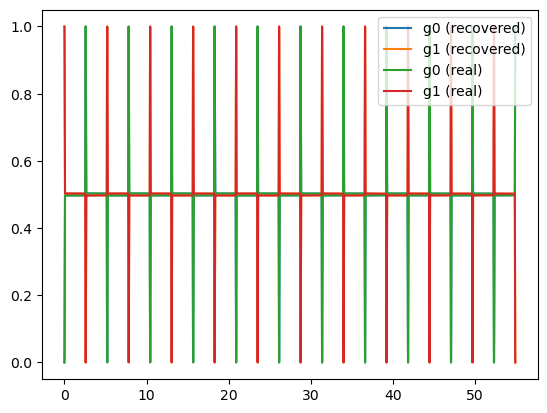

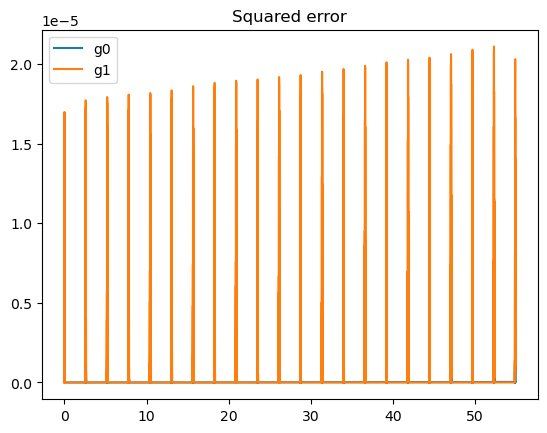

In [74]:

tlist_torch, states_torch = qutip_to_torch(t, result.states, device="cuda")
tlist_torch = tlist_torch.real
states_rot_torch = rotating_frame_states_torch(tlist_torch, states_torch, 2*np.pi*qargs['mw_fc'])

sx, sy, sz = pauli_torch(
    dtype=states_rot_torch.dtype,
    device=states_rot_torch.device
)

rx = expect_torch(sx, states_rot_torch)
ry = expect_torch(sy, states_rot_torch)
rz = expect_torch(sz, states_rot_torch)
r = torch.vstack([rx, ry, rz]).T  # (T,3)
r = r.real
rdot = torch.gradient(r, spacing=(tlist_torch,), dim=(0,))[0]
rdot = rdot.real
# Omega_perp = (r x rdot)/|r|^2
Omega_perp = torch.cross(r, rdot)/torch.linalg.norm(r, axis=1)[:, None]**2
r_rec = integrate_bloch_torch(Omega_perp, tlist_torch, r[0])

plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1+r_rec[:, 0, 2].cpu().numpy()), label='g0 (recovered)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1-r_rec[:, 0, 2].cpu().numpy()), label='g1 (recovered)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1+r[:, 2].cpu().numpy()), label='g0 (real)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1-r[:, 2].cpu().numpy()), label='g1 (real)')
plt.legend()
plt.show()

# #Plot omega-perp
# plt.figure()
# plt.plot(tlist_torch.cpu().numpy()*1e6, Omega_perp.cpu().numpy())
# plt.legend()
# plt.title('omega-perp')
# plt.show()
# square error

plt.figure()
plt.plot(t*1e6, ((r_rec[:, 0, 0] - r[:, 0])**2).cpu().numpy(), label='g0')
plt.plot(t*1e6, ((r_rec[:, 0, 1] - r[:, 1])**2).cpu().numpy(), label='g1')
plt.legend()
plt.title('Squared error')
plt.show()

torch.Size([3, 1])
torch.Size([1, 1])


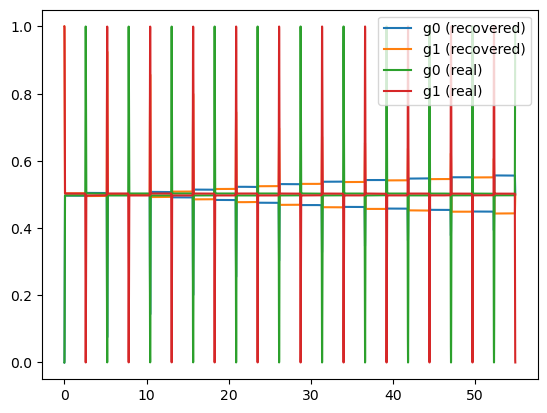

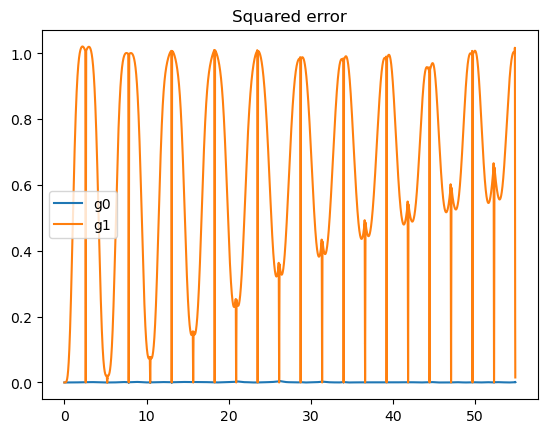

In [127]:
device = "cuda"
tlist_torch, states_torch = qutip_to_torch(t, result.states, device=device)
tlist_torch = tlist_torch.real

freqs = torch.linspace(1e3, 1e5, 400, device=device)
# amps = torch.zeros(freqs.shape, device=device)
amps = 1/freqs*1e9
spectrum_stepper = SpectrumStepper(amps, freqs, 1000)

states_rot_torch = rotating_frame_states_torch(tlist_torch, states_torch, 2*np.pi*qargs['mw_fc'])

sx, sy, sz = pauli_torch(
    dtype=states_rot_torch.dtype,
    device=states_rot_torch.device
)

rx = expect_torch(sx, states_rot_torch)
ry = expect_torch(sy, states_rot_torch)
rz = expect_torch(sz, states_rot_torch)
r = torch.vstack([rx, ry, rz]).T  # (T,3)
r = r.real
rdot = torch.gradient(r, spacing=(tlist_torch,), dim=(0,))[0]
rdot = rdot.real
# Omega_perp = (r x rdot)/|r|^2
Omega_perp = torch.cross(r, rdot)/torch.linalg.norm(r, axis=1)[:, None]**2
r_rec = integrate_bloch_torch(Omega_perp, tlist_torch, r[0], spectrum_stepper, avg_only=True)

plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1+r_rec[:, 0, 2].cpu().numpy()), label='g0 (recovered)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1-r_rec[:, 0, 2].cpu().numpy()), label='g1 (recovered)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1+r[:, 2].cpu().numpy()), label='g0 (real)')
plt.plot(tlist_torch.cpu().numpy()*1e6, 1/2*(1-r[:, 2].cpu().numpy()), label='g1 (real)')
plt.legend()
plt.show()

# #Plot omega-perp
# plt.figure()
# plt.plot(tlist_torch.cpu().numpy()*1e6, Omega_perp.cpu().numpy())
# plt.legend()
# plt.title('omega-perp')
# plt.show()
# square error

plt.figure()
plt.plot(t*1e6, ((r_rec[:, 0, 0] - r[:, 0])**2).cpu().numpy(), label='g0')
plt.plot(t*1e6, ((r_rec[:, 0, 1] - r[:, 1])**2).cpu().numpy(), label='g1')
plt.legend()
plt.title('Squared error')
plt.show()

100%|██████████| 1000/1000 [2:05:01<00:00,  7.50s/it] 


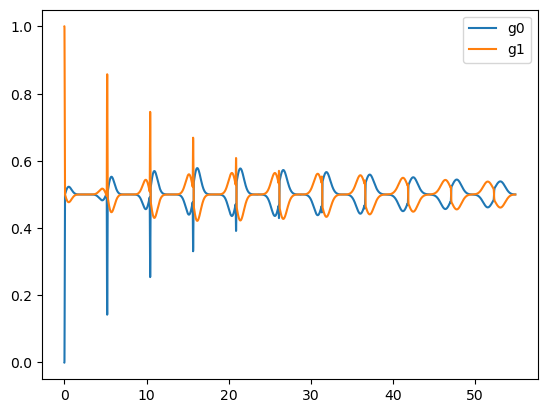

In [132]:
sum_states = None
for n_i in tqdm(range(spectrum_stepper.n)):
    wait_times = np.linspace(5e-6, 50e-6, 1)
    transfer = []
    for wait_time in wait_times:
        ramsey_flips = 20
        ramsey_sequence = {
            'mw' : {'pulse_train' : ['pi/2_X', wait_time/2-26.25e-9, 'pi_X'] + [wait_time/2, 'pi_X']*(ramsey_flips-1) + [wait_time/2-26.25e-9, 'pi/2_X']},
            # 'optical' : {'pulse_train' : [\pulses['pi/2']['width'], wait_time, pulses['pi/2']['width'], wait_time, 'readout_up']}
        }
        t = np.arange(0, get_pulse_train_time(ramsey_sequence), 1/6.144e9)
        ramsey_sigs = process_pulse_train(t, ramsey_sequence, plot=False) 
        qargs['sigmaz_noise_fn'] = lambda t: spectrum_stepper.evaluate(t, n_i).cpu().numpy()[:, 0]
        q = qc.ColorCenterQubit(**qargs)
        result = q.apply_pulse_sequence(t, ramsey_sigs, plot=False)
        if sum_states is None:
            sum_states = result.states
        else:
            sum_states = [sum_states[i] + result.states[i] for i in range(len(sum_states))]

average_state = [state/spectrum_stepper.n for state in sum_states]

sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()

# Bloch vector r(t)
rx = np.array([qt.expect(sx, st) for st in average_state])
ry = np.array([qt.expect(sy, st) for st in average_state])
rz = np.array([qt.expect(sz, st) for st in average_state])

plt.figure()
# plt.plot(t*1e6, rx, label='x')
# plt.plot(t*1e6, ry, label='y')
plt.plot(t*1e6, 1/2*(1+rz), label='g0')
plt.plot(t*1e6, 1/2*(1-rz), label='g1')
plt.legend()
plt.show()
